In [1]:
import load
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dataset = load.load_consumption_csv('./data/energy-consumption-us/ATSI_region_3yr.csv')
#dataset = load.load_consumption_csv('./data/energy-consumption-us/mini.csv')
#dataset = load.load_consumption_csv('./data/energy-consumption-us/super-mini.csv')

In [3]:
dataset[0]

{'datetime_beginning_utc': Timestamp('2018-01-01 05:00:00'),
 'datetime_beginning_ept': Timestamp('2018-01-01 00:00:00'),
 'nerc_region': 'RFC',
 'mkt_region': 'WEST',
 'zone': 'ATSI',
 'load_area': 'OE',
 'mw': 7261.097,
 'is_verified': True}

In [4]:
import statistics

volume_by_date = {}

for row in dataset:
    ts = row['datetime_beginning_ept'] 
    date = ts.date()
    if date not in volume_by_date:
        volume_by_date[date] = []
        
    volume_by_date[date].append(row['mw'])

for date in volume_by_date:
    volume_by_date[date] = np.sum(volume_by_date[date])

volume_by_date = list(volume_by_date.items())
    
volume_by_date.sort(key=lambda tup: tup[0])

## Plot the data

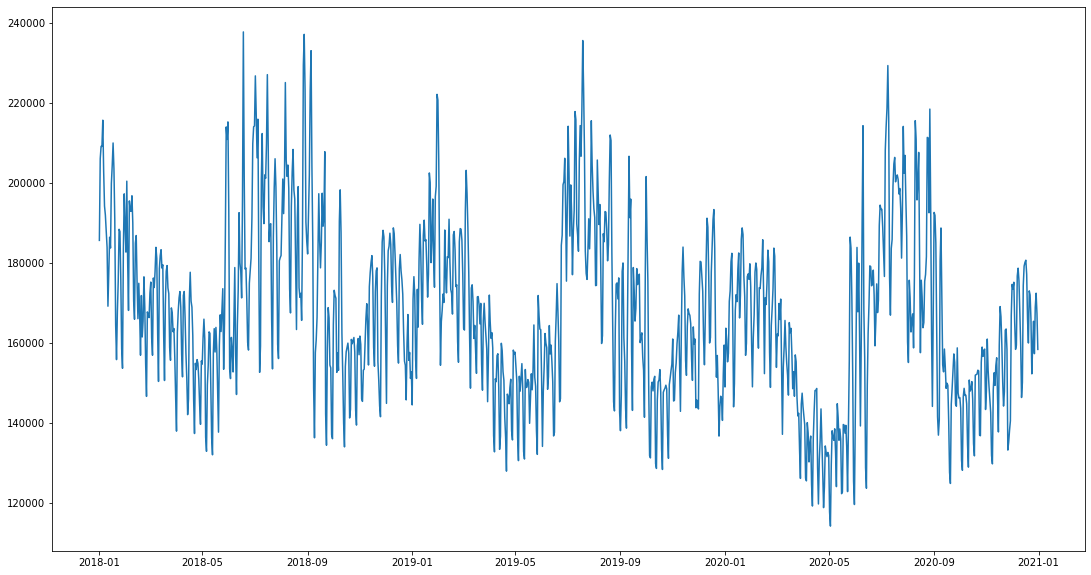

In [5]:
x, y = zip(*volume_by_date)

fig = plt.figure()
fig.set_size_inches(18.5, 10)
ax = fig.add_subplot(111)
_ = ax.plot(x, y)

## Mark January, July

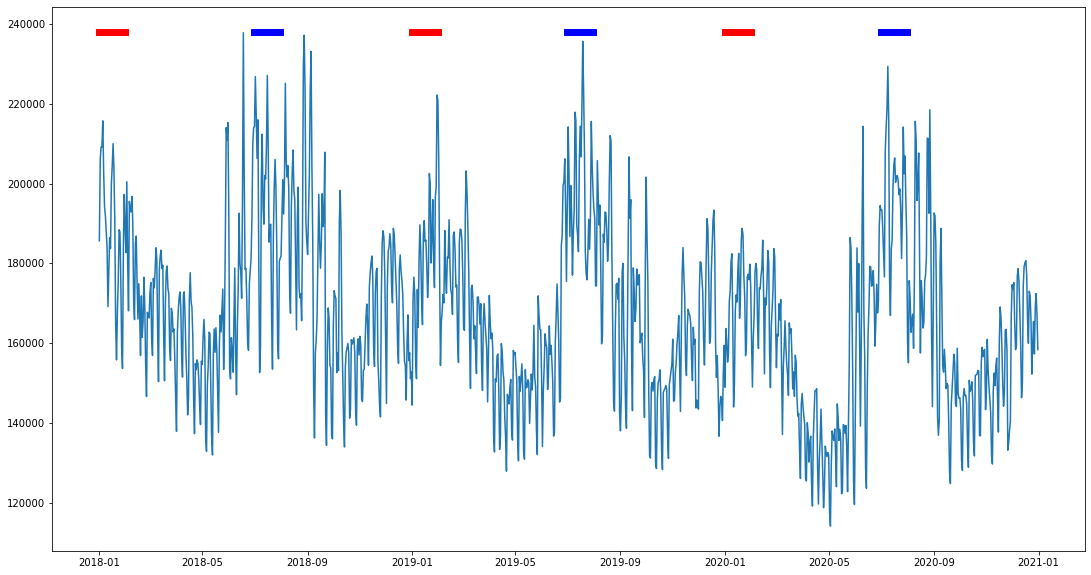

In [6]:
x, y = zip(*(volume_by_date))

## (Monday).weekday == 0
magic_val = int(max(y)) + 200
july = [magic_val if ts.month == 7 else None for ts in x]
jan = [magic_val if ts.month == 1 else None for ts in x]


fig = plt.figure()
fig.set_size_inches(18.5, 10)
ax = fig.add_subplot(111)
_ = ax.plot(x, y)
_ = ax.plot(x, july, 'bs')
_ = ax.plot(x, jan, 'rs')

## Histogram

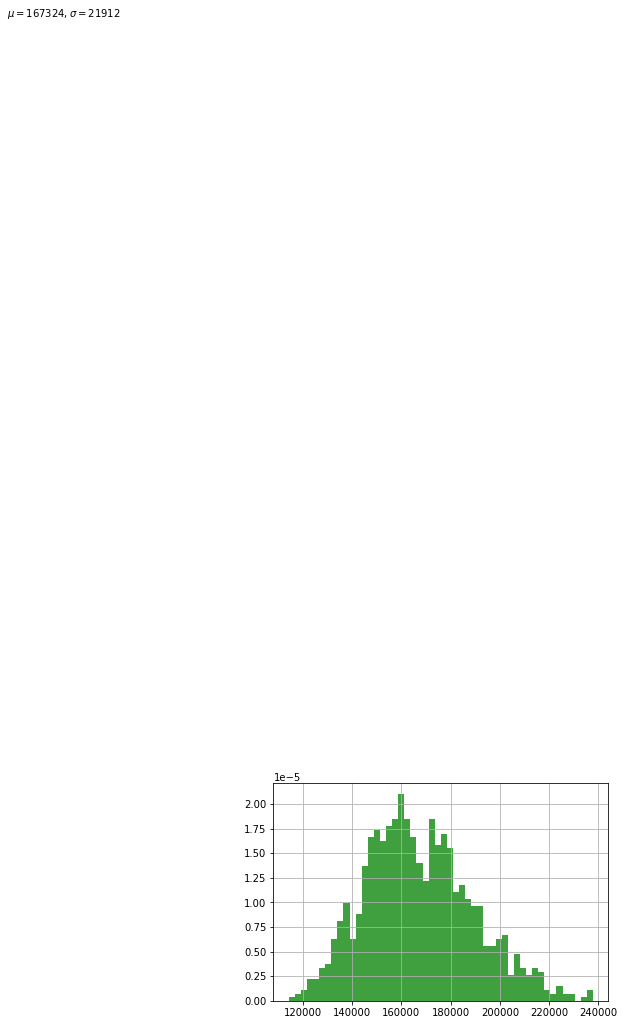

In [7]:
n, bins, patches = plt.hist(y, 50, density=True, facecolor='g', alpha=0.75)

mu = np.mean(y)
std = np.std(np.array(y))

plt.text(0, 0.0001, "$\mu=$"+str(round(mu))+'$,\sigma=$'+str(round(std)))
plt.grid(True)

## Stationarity

In [8]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

(adf_stat, p_value, _, _, critical_values, _, ) = adfuller(y)
print('ADF Statistic: %f' % adf_stat)
print('p-value: %f' % p_value)
print("Critical value %%1: %f" % critical_values['1%'])
    
if p_value < 0.05 and adf_stat < critical_values['1%']:
    print("Time series is stationary")

ADF Statistic: -3.615261
p-value: 0.005476
Critical value %1: -3.436453
Time series is stationary


## Make up some features

* Day of week
* Month of year 
* Time of day

In [9]:
import math

day_of_week = np.array([date.weekday() for date in x])
isocalendar = np.array([date.isocalendar() for date in x])  
week_of_year = isocalendar[:,1]
#month = np.array([date.month - 1 for date in x]) # smh Jan is 1 - shift it down


### Check how balanced are the values

In [10]:
print(np.bincount(day_of_week))
print(np.bincount(week_of_year))

[157 157 157 157 156 156 156]
[ 0 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21
 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21
 21 21 21 21 21  4]


## Fit trend line

In [11]:
from sklearn.linear_model import LinearRegression
import datetime

time = datetime.time(1,1)

X_timestamps = np.array([datetime.datetime.combine(date, time).timestamp() for date in x]).reshape(-1, 1)

reg = LinearRegression().fit(X_timestamps, y)
reg.score(X_timestamps, y)

0.06265204523815449

In [12]:
reg.coef_

array([-0.00020064])

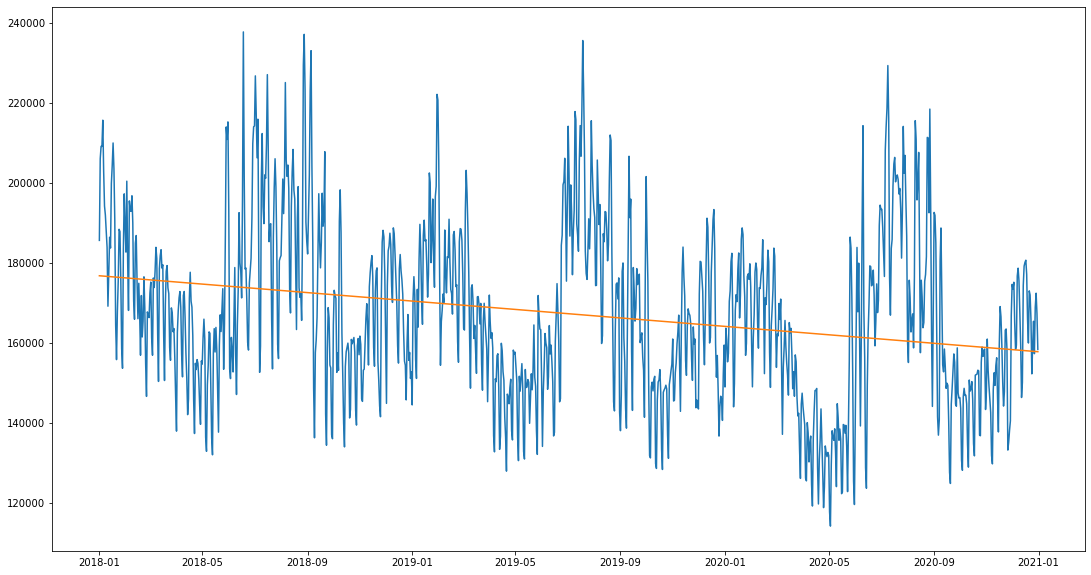

In [13]:
y_pred = reg.predict(X_timestamps)

fig = plt.figure()
fig.set_size_inches(18.5, 10)
ax = fig.add_subplot(111)
_ = ax.plot(x, y)
_ = ax.plot(x, y_pred)

## Fit linear regression with one-hot

In [14]:
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

day_of_week_1h = get_one_hot(day_of_week, 7)
week_of_year_1h = get_one_hot(week_of_year, 54)

X_1h = np.concatenate((day_of_week_1h,week_of_year_1h),axis=1)

In [15]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_1h, y)
reg.score(X_1h, y)

0.6053895036484129

# Plot the fit 

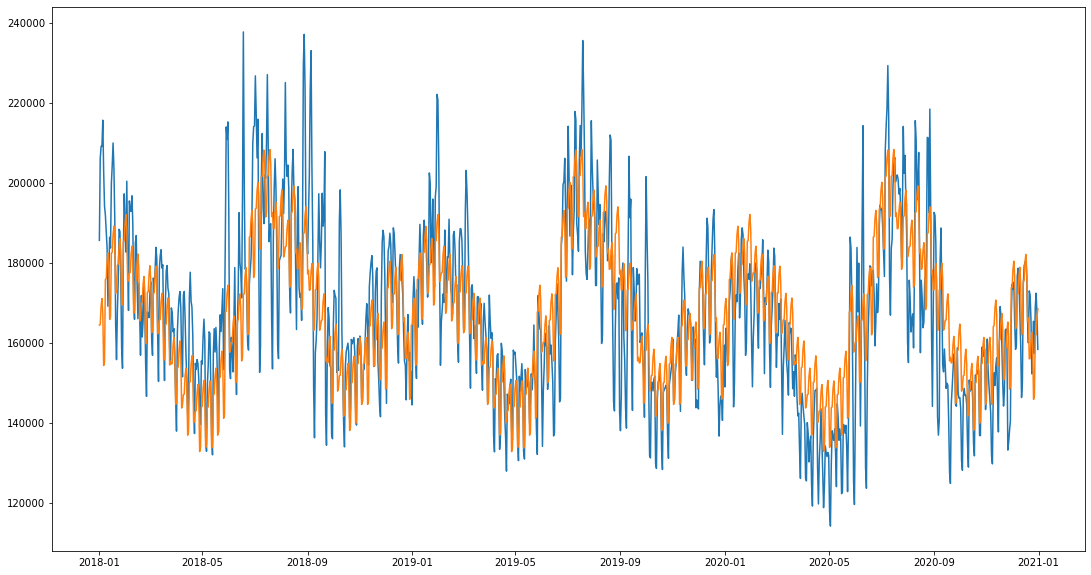

In [16]:
y_pred_1h = reg.predict(X_1h)

fig = plt.figure()
fig.set_size_inches(18.5, 10)
ax = fig.add_subplot(111)
_ = ax.plot(x, y)
_ = ax.plot(x, y_pred_1h)

## Fit GP vs timestamp (basically memorize the data)

In [17]:
import GPy

GPy.plotting.change_plotting_library('plotly_offline')

 /home/model/anaconda3/lib/python3.8/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




# Normalization

In [18]:
X_timestamps

array([[1.51476486e+09],
       [1.51485126e+09],
       [1.51493766e+09],
       ...,
       [1.60920006e+09],
       [1.60928646e+09],
       [1.60937286e+09]])

In [19]:
def normalize_single_feature(arr, arr_min, arr_max):
    return ((arr - arr_min)/(arr_max-arr_min)).T

# normalize X
normalization_x_timestamps_min = np.min(X_timestamps)
normalization_x_timestamps_max = np.max(X_timestamps)

X_timestamps_normalized = normalize_single_feature(X_timestamps,
    normalization_x_timestamps_min,normalization_x_timestamps_max).reshape(-1,1)



# normalize Y
y = np.array(y)
normalization_y_min = 0
normalization_y_max = 500000

y_normalized = normalize_single_feature(y,normalization_y_min,normalization_y_max).reshape(-1,1)

In [20]:
#kernel_rbf = GPy.kern.RBF(input_dim=1, variance=5, lengthscale=0.1)
#kernel_brownian = GPy.kern.Brownian(input_dim=3, variance=10)
#kernel_lin = GPy.kern.Linear(input_dim=1)
_='''
kernel = GPy.kern.StdPeriodic(1, period=0.1) + GPy.kern.StdPeriodic(1, period=0.03) + GPy.kern.Linear(input_dim=1)

m = GPy.models.GPRegression(X_timestamps_normalized,y_normalized,kernel, normalizer=True)

m.optimize(messages=True)
#m.optimize_restarts(num_restarts = 1)

fig = m.plot(title='1d_gp')
GPy.plotting.show(fig, filename='1d_gp')
'''


## Fit GP vs decomposed time features

In [21]:
normalization_day_of_week_min = np.min(day_of_week)
normalization_day_of_week_max = np.max(day_of_week)
normalization_week_of_year_min = np.min(week_of_year)
normalization_week_of_year_max = np.max(week_of_year)

week_of_year_normalized = normalize_single_feature(week_of_year, normalization_week_of_year_min, normalization_week_of_year_max).reshape(-1,1)
day_of_week_normalized = normalize_single_feature(day_of_week, normalization_day_of_week_min, normalization_day_of_week_max).reshape(-1,1)

X_decomp_time_features = np.concatenate((week_of_year_normalized,day_of_week_normalized), axis=1) 

# add noise
X_decomp_time_features += np.random.normal(0, 0.01, X_decomp_time_features.shape)

In [22]:
kernel_lin = GPy.kern.Linear(input_dim=2)
kernel_periodic_1 = GPy.kern.StdPeriodic(2, period=0.1)
kernel_periodic_2 = GPy.kern.StdPeriodic(2, period=0.05)
kernel = kernel_periodic_1 + kernel_periodic_2 + kernel_lin

m = GPy.models.GPRegression(X_decomp_time_features,y_normalized,kernel)

m.optimize(messages=True)
m.optimize_restarts(num_restarts = 3)

Optimization restart 1/3, f = -1939.4809979540314
Optimization restart 2/3, f = -2314.4849926984225
Optimization restart 3/3, f = -2298.234093793139


In [23]:
fig = m.plot(title='1d_gp')

GPy.plotting.show(fig, filename='1d_gp')

/home/model/anaconda3/lib/python3.8/site-packages/plotly/tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead

/home/model/anaconda3/lib/python3.8/site-packages/plotly/graph_objs/_deprecations.py:322: DeprecationWarning:

plotly.graph_objs.Font is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Font
  - plotly.graph_objs.layout.hoverlabel.Font
  - etc.


/home/model/anaconda3/lib/python3.8/site-packages/plotly/graph_objs/_deprecations.py:434: DeprecationWarning:

plotly.graph_objs.Marker is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Marker
  - plotly.graph_objs.histogram.selected.Marker
  - etc.




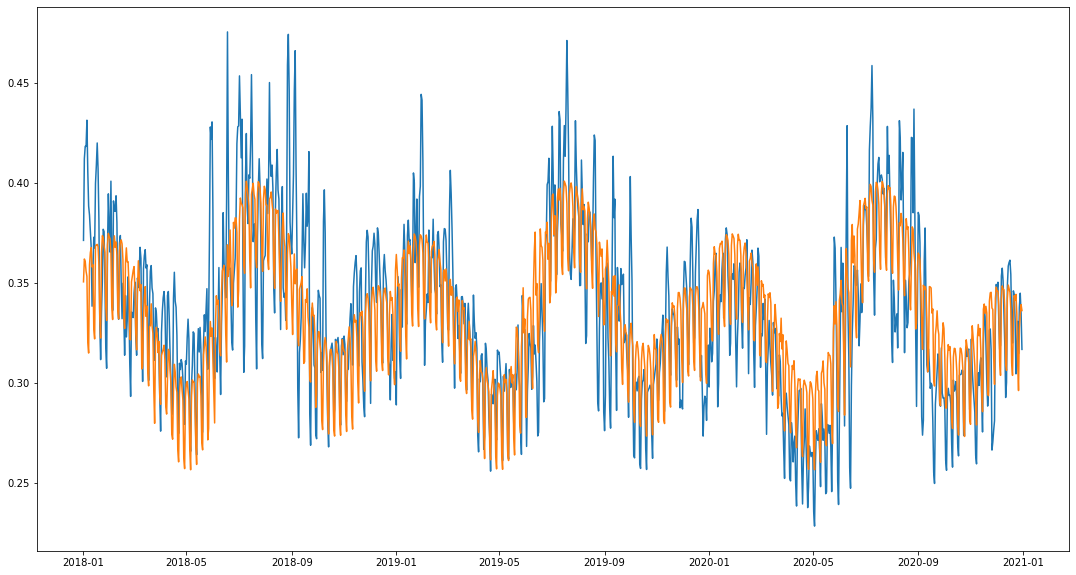

In [24]:
gp_pred = m.predict(X_decomp_time_features)

fig = plt.figure()
fig.set_size_inches(18.5, 10)
ax = fig.add_subplot(111)
_ = ax.plot(x, y_normalized)
_ = ax.plot(x, gp_pred[0])

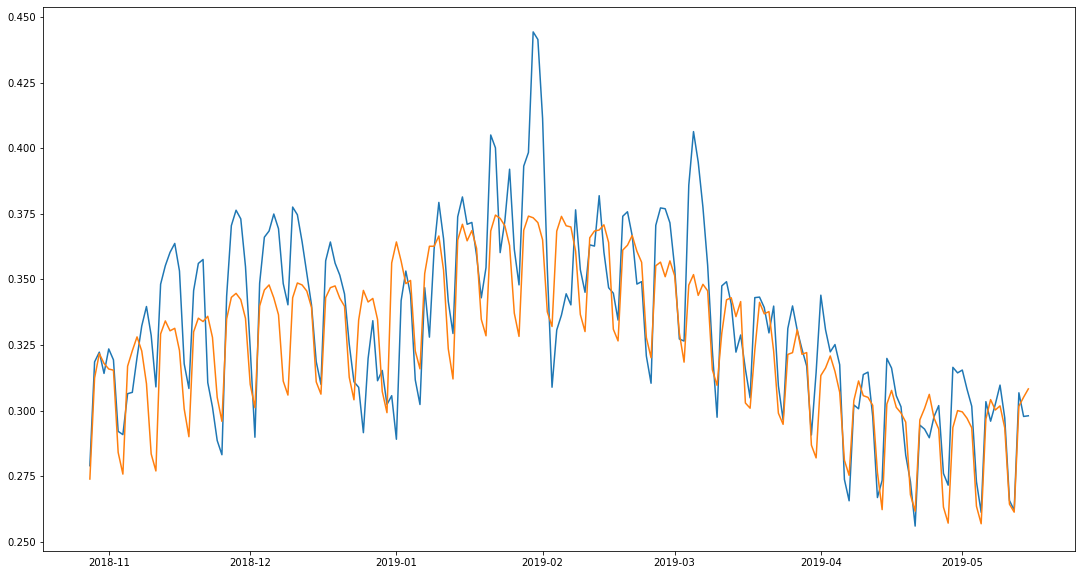

In [25]:
gp_pred = m.predict(X_decomp_time_features)

start = 300
end = 500

fig = plt.figure()
fig.set_size_inches(18.5, 10)
ax = fig.add_subplot(111)
_ = ax.plot(x[start:end], y_normalized[start:end])
_ = ax.plot(x[start:end], gp_pred[0][start:end])

## Fit n+1 timestep model

In [26]:
X_decomp_time_and_previous_step = np.concatenate((X_decomp_time_features[1:], y_normalized[:-1]), axis=1)

y_normalized_without_first = y_normalized[1:]

In [52]:
kernel_periodic = GPy.kern.StdPeriodic(2, period=0.1, active_dims=[0,1])
kernel_rbf = GPy.kern.RBF(input_dim=3, variance=1, lengthscale=1)
kernel_bias = GPy.kern.Bias(3, variance=1, lengthscale=1)

kernel = kernel_periodic + kernel_rbf

m2 = GPy.models.GPRegression(X_decomp_time_and_previous_step,y_normalized_without_first,kernel)
#m2.Gaussian_noise.variance.constrain_bounded(0.001, 100)
m2.optimize(messages=True)
m2.optimize_restarts(num_restarts=2)

Optimization restart 1/2, f = -2824.4955282300343
Optimization restart 2/2, f = -2800.1637144321594


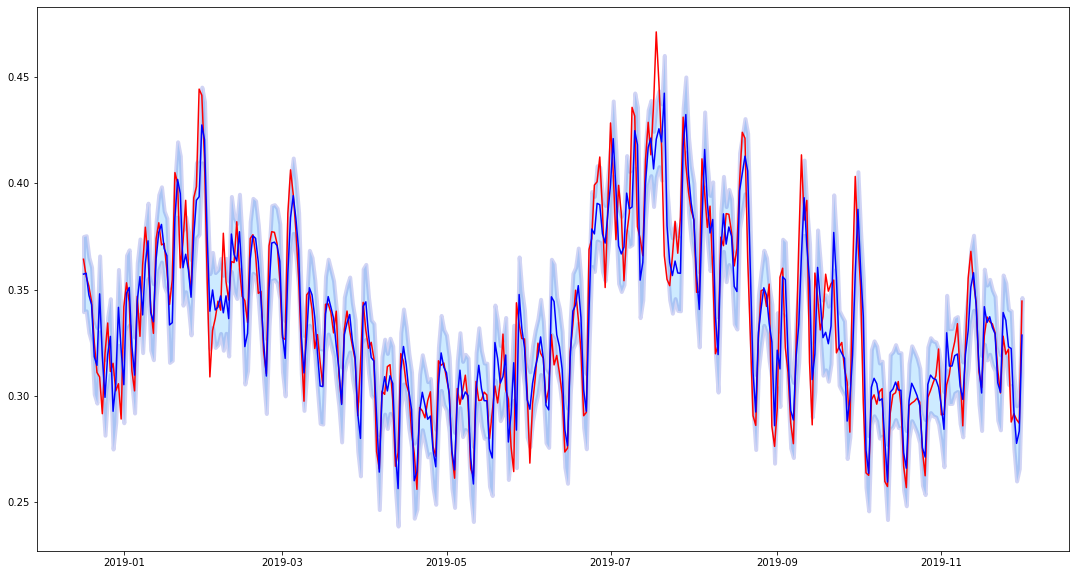

In [53]:
gp_pred = m2.predict(X_decomp_time_and_previous_step)

start = 350
end = 700


pred = gp_pred[0][start:end]
err = np.sqrt(gp_pred[1][start:end])

fig = plt.figure()
fig.set_size_inches(18.5, 10)
ax = fig.add_subplot(111)
_ = ax.plot(x[start:end], y_normalized_without_first[start:end], 'r')
_ = ax.plot(x[start:end], pred, 'b')

_ = ax.fill_between(x[start:end], (pred-err).flatten(), (pred+err).flatten(),
    alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
    linewidth=4, antialiased=True)

In [54]:
m.save_model("demand-sim")
m2.save_model("demand-pred")

In [55]:
print(normalization_day_of_week_min)
print(normalization_day_of_week_max)
print(normalization_week_of_year_min)
print(normalization_week_of_year_max)
print(normalization_y_min)
print(normalization_y_max)

0
6
1
53
0
500000


In [56]:
preds = np.ones((10,54*7-7))

last_predict = 0.3
for i in range(0, 10):
    for week_index in range(1,54):
        for day_index in range(0,7):
            #X = np.array([[(week_index-1)/53.0, (day_index-1)/6.0]])
            #last_predict = m.posterior_samples(X, size=1)[0][0][0]
            
            X = np.array([[week_index/53.0, day_index/6.0, last_predict]])
            pred = m2.posterior_samples(X)[0][0][0]
            last_predict = pred 
            preds[i][week_index * 7 + day_index - 7] = pred
            

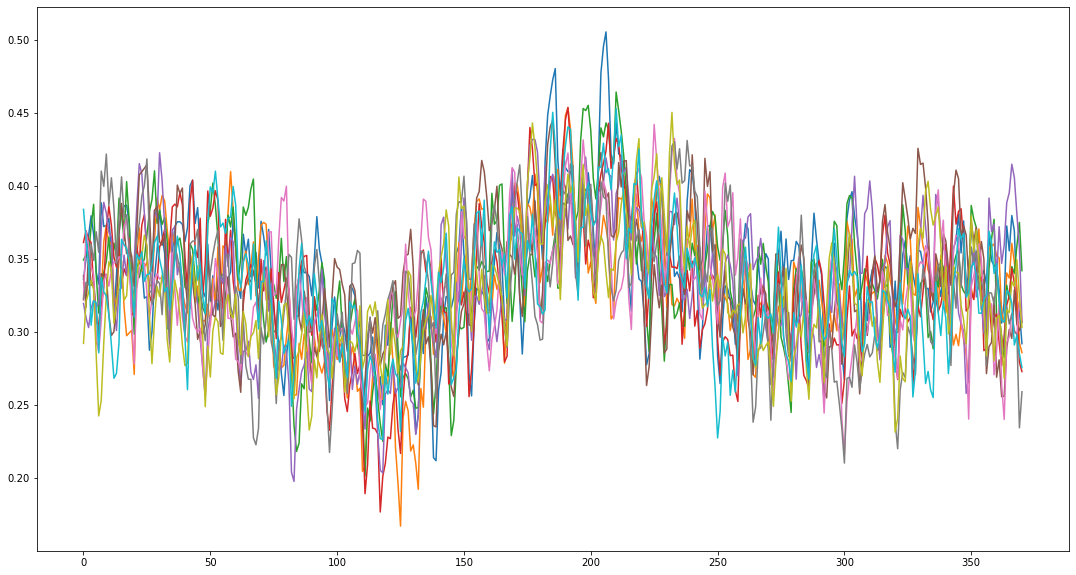

In [57]:
fig = plt.figure()
fig.set_size_inches(18.5, 10)
ax = fig.add_subplot(111)


for i in range(0, 10):
    _ = ax.plot(preds[i])